In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Function to load data from directory
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

# Load train, test, and validation datasets
train = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\train')
test = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test')
valid = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\valid')

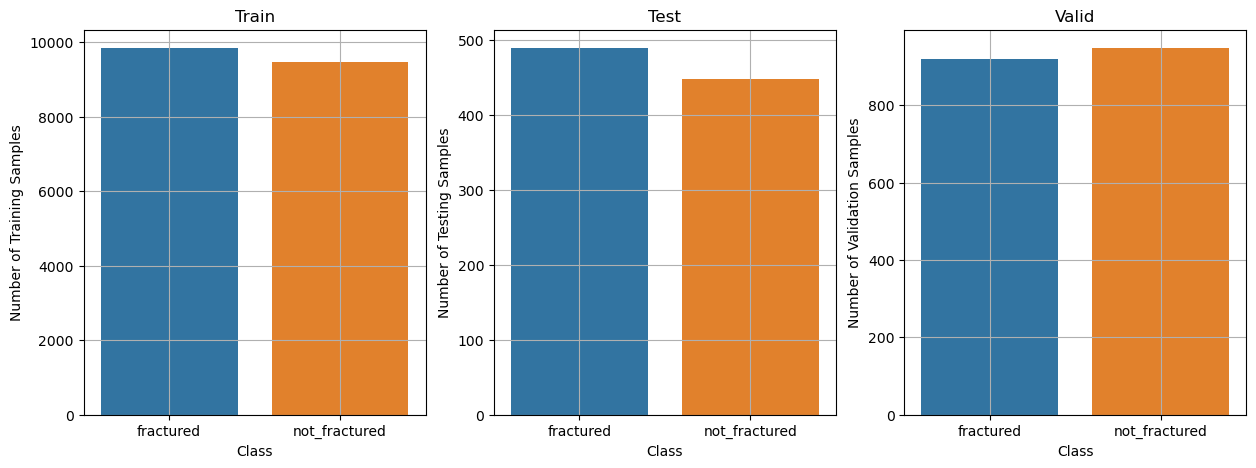

In [3]:
# Plotting class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train.label)
plt.xlabel("Class")
plt.ylabel("Number of Training Samples")
plt.title('Train')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.countplot(x=test.label)
plt.xlabel("Class")
plt.ylabel("Number of Testing Samples")
plt.title('Test')
plt.grid(True)
plt.subplot(1, 3, 3)
sns.countplot(x=valid.label)
plt.xlabel("Class")
plt.ylabel("Number of Validation Samples")
plt.title('Valid')
plt.grid(True)
plt.show()

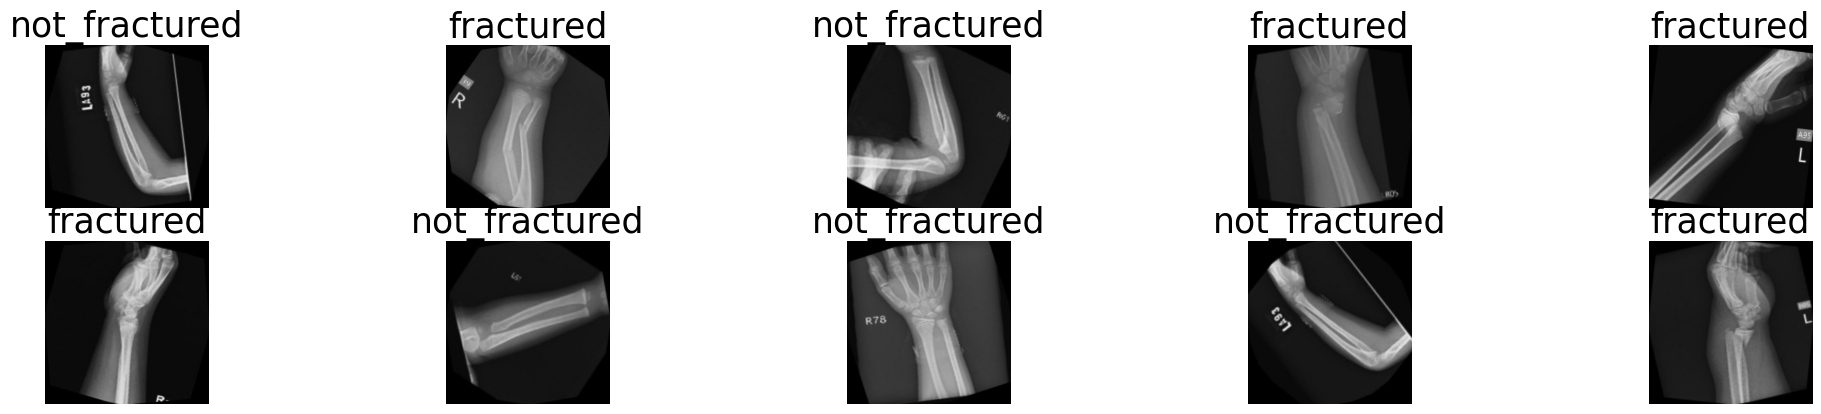

In [4]:
# Displaying some sample images
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train.label[i], fontsize=25)

In [5]:
# Setting up ImageDataGenerator
image_size = (128, 128)
batch_size = 32
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_dataframe(train, x_col='image', y_col='label', target_size=image_size,
                                              batch_size=batch_size, class_mode='binary', shuffle=True)
test_generator = datagen.flow_from_dataframe(test, x_col='image', y_col='label', target_size=image_size,
                                             batch_size=batch_size, class_mode='binary', shuffle=False)
valid_generator = datagen.flow_from_dataframe(valid, x_col='image', y_col='label', target_size=image_size,
                                              batch_size=batch_size, class_mode='binary', shuffle=True)

Found 19329 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1868 validated image filenames belonging to 2 classes.


In [7]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=vgg16.input, outputs=Flatten()(vgg16.output))

In [8]:
def extract_features(generator):
    features = []
    labels = []
    batch_size = generator.batch_size
    for batch in generator:
        images, label = batch
        
        batch_features = feature_extractor.predict(images)
        features.append(batch_features)
        labels.append(label)
        
        if len(features) * batch_size >= len(generator.filenames):
            break
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

In [9]:
X_train, y_train = extract_features(train_generator)
X_valid, y_valid = extract_features(valid_generator)
X_test, y_test = extract_features(test_generator)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 697ms/step


In [10]:
# Reshape labels to be 1D for SVM
y_train = y_train.flatten()
y_valid = y_valid.flatten()
y_test = y_test.flatten()

In [11]:
# Applying PCA to reduce dimensions of extracted features
pca = PCA(n_components=12000)  
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [12]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)
y_test_enc = label_encoder.transform(y_test)

In [13]:
param_grid = {'C': [100], 'kernel': ['linear']}
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_pca, y_train_enc)

GridSearchCV(cv=5, error_score='raise', estimator=SVC(probability=True),
             n_jobs=-1, param_grid={'C': [100], 'kernel': ['linear']},
             scoring='accuracy')

In [14]:
best_svm = grid_search.best_estimator_

In [15]:
y_valid_pred = best_svm.predict(X_valid_pca)
valid_accuracy = accuracy_score(y_valid_enc, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.4f}')

Validation Accuracy: 0.8153


In [16]:
y_test_pred = best_svm.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8365


In [17]:
target_names = [str(label) for label in label_encoder.classes_]
conf_matrix = confusion_matrix(y_test_enc, y_test_pred)
target_names = ['Fracture', 'Not Fracture']
report = classification_report(y_test_enc, y_test_pred, target_names=target_names)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[412  77]
 [ 76 371]]

Classification Report:
               precision    recall  f1-score   support

    Fracture       0.84      0.84      0.84       489
Not Fracture       0.83      0.83      0.83       447

    accuracy                           0.84       936
   macro avg       0.84      0.84      0.84       936
weighted avg       0.84      0.84      0.84       936



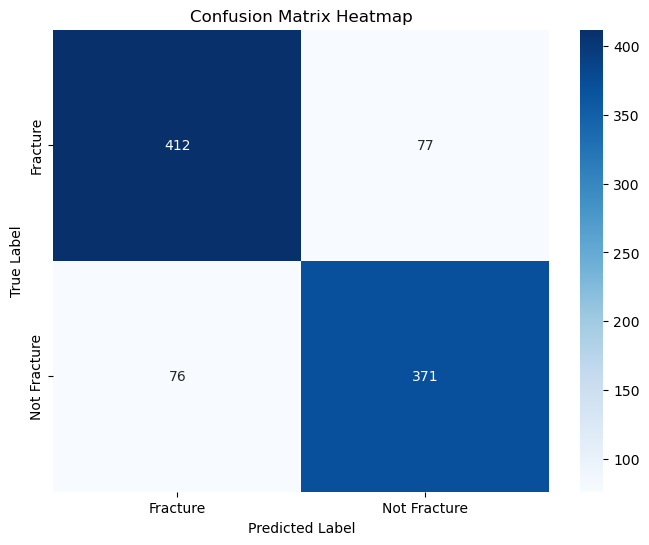

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [19]:
X_test_pca = pca.transform(X_test)

In [20]:
y_test_prob = best_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_enc, y_test_prob)
roc_auc = auc(fpr, tpr)

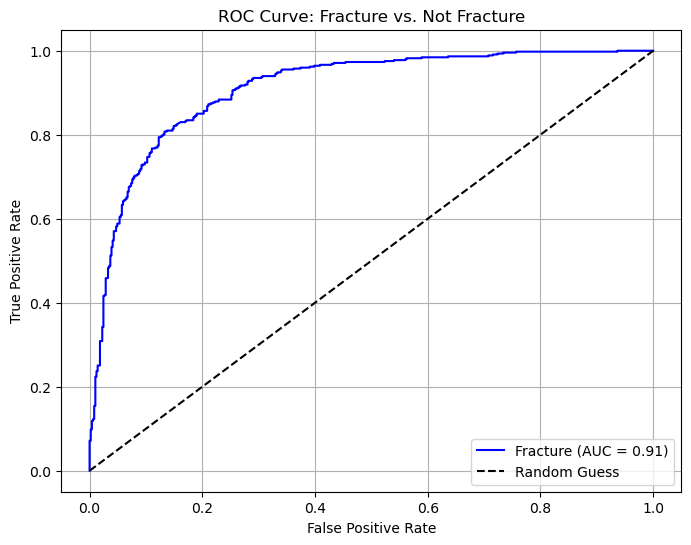

In [21]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Fracture (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Fracture vs. Not Fracture')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [23]:
y_test_proba = best_svm.predict_proba(X_test_pca)[:, 1]
y_valid_proba = best_svm.predict_proba(X_valid_pca)[:, 1]

In [24]:
fpr_test, tpr_test, _ = roc_curve(y_test_enc, y_test_proba)
auc_test = auc(fpr_test, tpr_test)
fpr_valid, tpr_valid, _ = roc_curve(y_valid_enc, y_valid_proba)
auc_valid = auc(fpr_valid, tpr_valid)

In [25]:
test_accuracy = accuracy_score(y_test_enc, best_svm.predict(X_test_pca))
valid_accuracy = accuracy_score(y_valid_enc, y_valid_pred)

In [26]:
def calculate_specificity_at_sensitivity(y_true, y_pred, sensitivity_threshold=0.95):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return specificity if sensitivity >= sensitivity_threshold else None

In [27]:
specificity_test = calculate_specificity_at_sensitivity(y_test_enc, best_svm.predict(X_test_pca))
specificity_valid = calculate_specificity_at_sensitivity(y_valid_enc, y_valid_pred)

In [28]:
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.4f}')
print(f'Test AUC: {auc_test:.4f}')
print(f'Validation AUC: {auc_valid:.4f}')
print(f'Test Specificity at Sensitivity ≥ 0.95: {specificity_test}')
print(f'Validation Specificity at Sensitivity ≥ 0.95: {specificity_valid}')

Test Accuracy: 0.8365
Validation Accuracy: 0.8153
Test AUC: 0.9102
Validation AUC: 0.8924
Test Specificity at Sensitivity ≥ 0.95: None
Validation Specificity at Sensitivity ≥ 0.95: None


1/1 [==============================] - 2s 2s/step


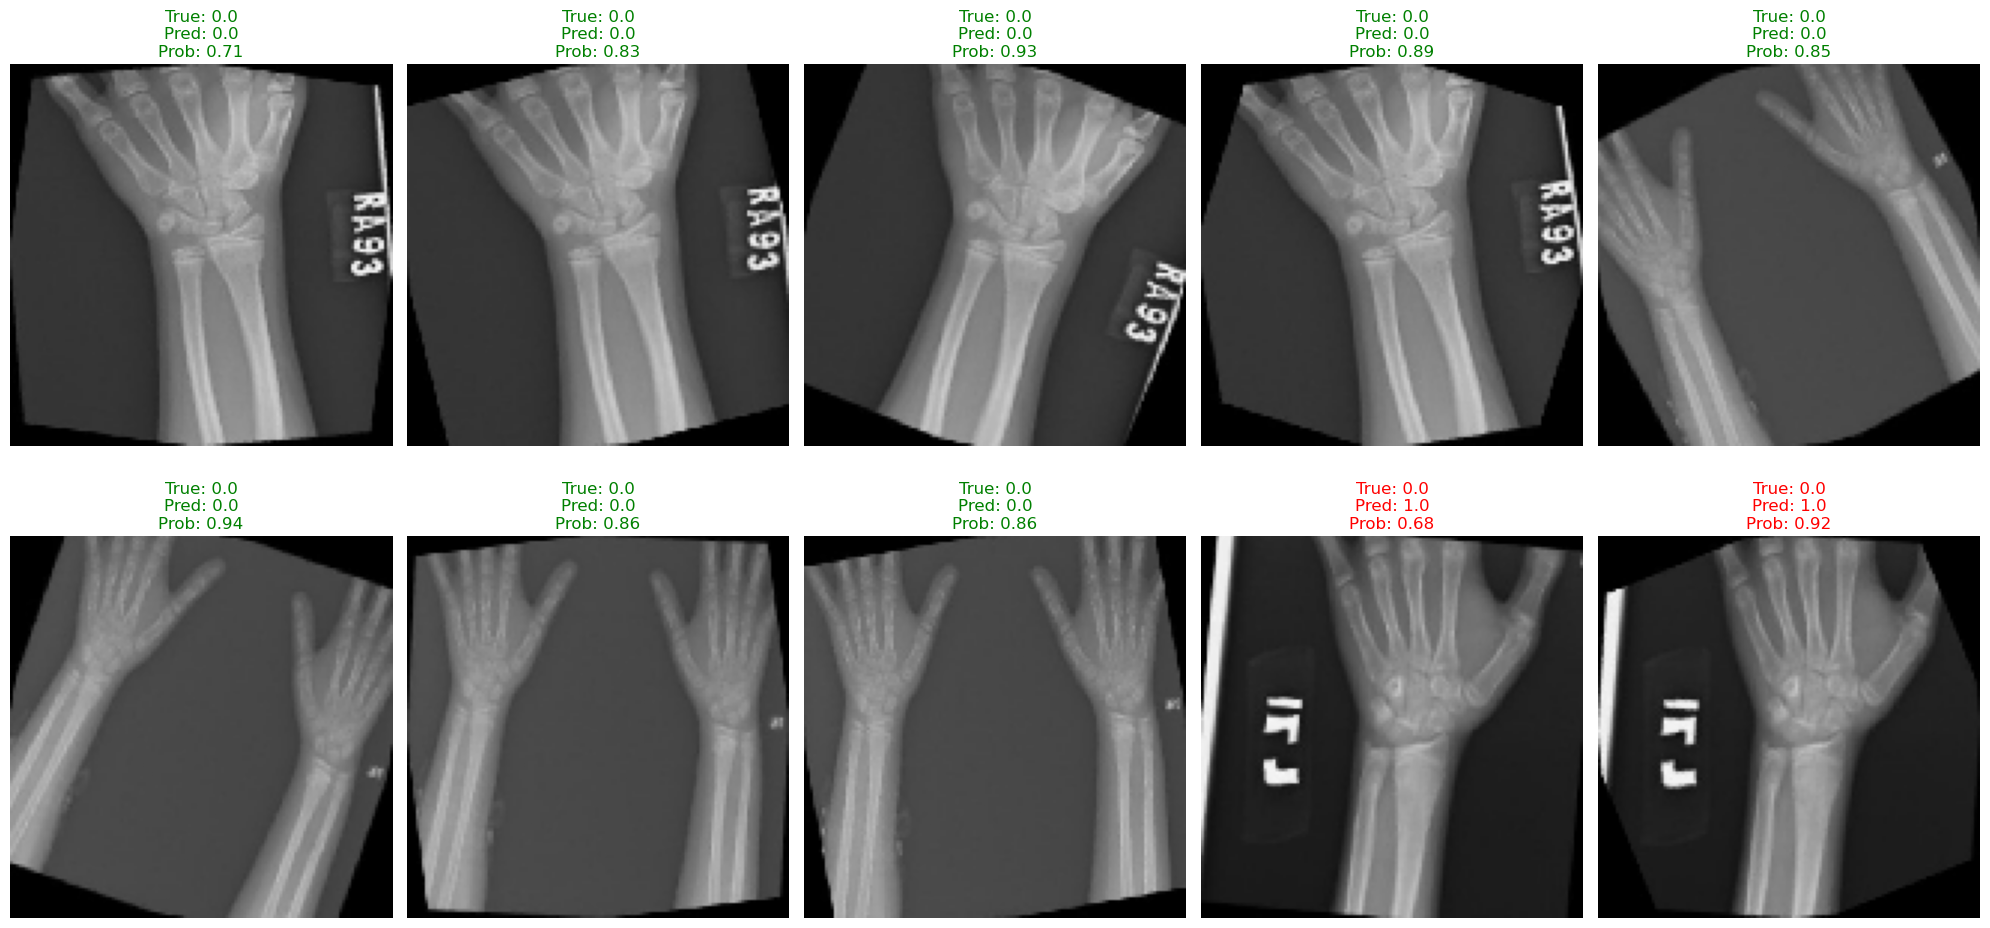

In [32]:
def display_predictions(generator, feature_extractor, pca, svm_model, label_encoder, num_images=10):
    
    images, true_labels = next(generator)

    
    extracted_features = feature_extractor.predict(images)

   
    reduced_features = pca.transform(extracted_features)

   
    predicted_probs = svm_model.predict_proba(reduced_features)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    
    true_labels_decoded = label_encoder.inverse_transform(true_labels.flatten().astype(int))
    predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

   
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(
            f"True: {true_labels_decoded[i]}\nPred: {predicted_labels_decoded[i]}\nProb: {predicted_probs[i].max():.2f}",
            fontsize=12,
            color="green" if true_labels_decoded[i] == predicted_labels_decoded[i] else "red"
        )
    plt.tight_layout()
    plt.show()


display_predictions(test_generator, feature_extractor, pca, best_svm, label_encoder)

In [33]:
metrics_dict = {
    'accuracy': [test_accuracy],  
    'val_accuracy': [valid_accuracy], 
    'specificity_at_sensitivity': [specificity_test if specificity_test is not None else 0],  
    'val_specificity_at_sensitivity': [specificity_valid if specificity_valid is not None else 0],  
    'auc': [auc_test], 
    'val_auc': [auc_valid] 
}
hist_ = pd.DataFrame(metrics_dict)
print(hist_)

   accuracy  val_accuracy  specificity_at_sensitivity  \
0  0.836538       0.81531                           0   

   val_specificity_at_sensitivity       auc   val_auc  
0                               0  0.910226  0.892439  


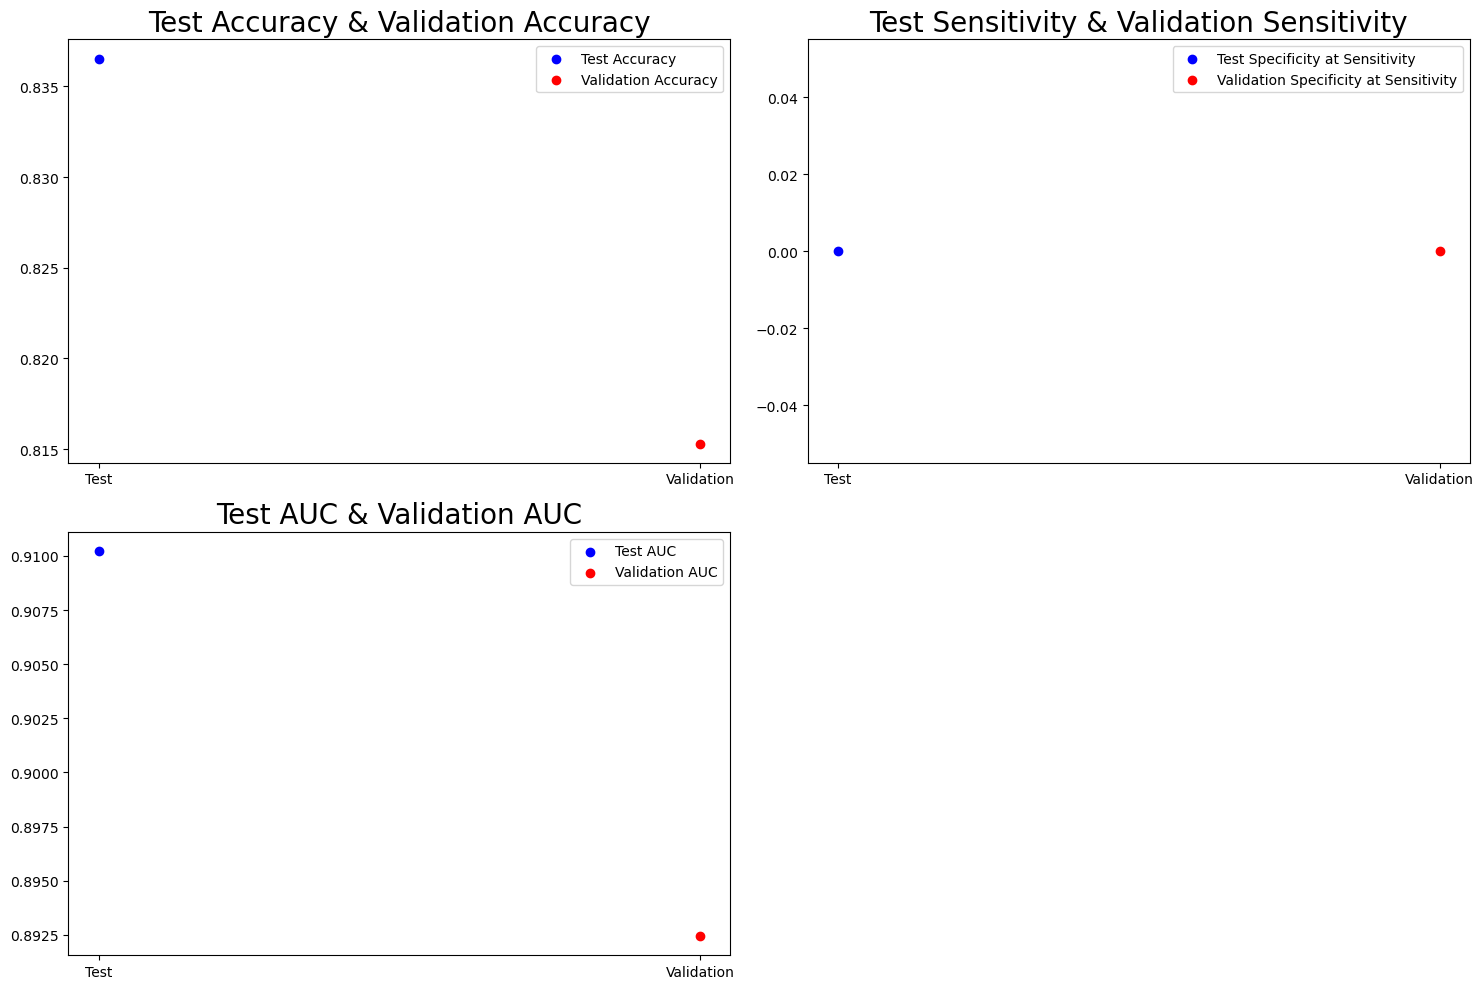

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(['Test'], hist_['accuracy'], color='b', label='Test Accuracy')
plt.scatter(['Validation'], hist_['val_accuracy'], color='r', label='Validation Accuracy')
plt.title('Test Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.subplot(2, 2, 2)
plt.scatter(['Test'], hist_['specificity_at_sensitivity'], color='b', label='Test Specificity at Sensitivity')
plt.scatter(['Validation'], hist_['val_specificity_at_sensitivity'], color='r', label='Validation Specificity at Sensitivity')
plt.title('Test Sensitivity & Validation Sensitivity', fontsize=20)
plt.legend()
plt.subplot(2, 2, 3)
plt.scatter(['Test'], hist_['auc'], color='b', label='Test AUC')
plt.scatter(['Validation'], hist_['val_auc'], color='r', label='Validation AUC')
plt.title('Test AUC & Validation AUC', fontsize=20)
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
target_names = [str(label) for label in label_encoder.classes_]
conf_matrix = confusion_matrix(y_test_enc, y_test_pred)
target_names = ['Fracture (0)', 'Not Fracture (1)']
report = classification_report(y_test_enc, y_test_pred, target_names=target_names)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[412  77]
 [ 76 371]]

Classification Report:
                   precision    recall  f1-score   support

    Fracture (0)       0.84      0.84      0.84       489
Not Fracture (1)       0.83      0.83      0.83       447

        accuracy                           0.84       936
       macro avg       0.84      0.84      0.84       936
    weighted avg       0.84      0.84      0.84       936



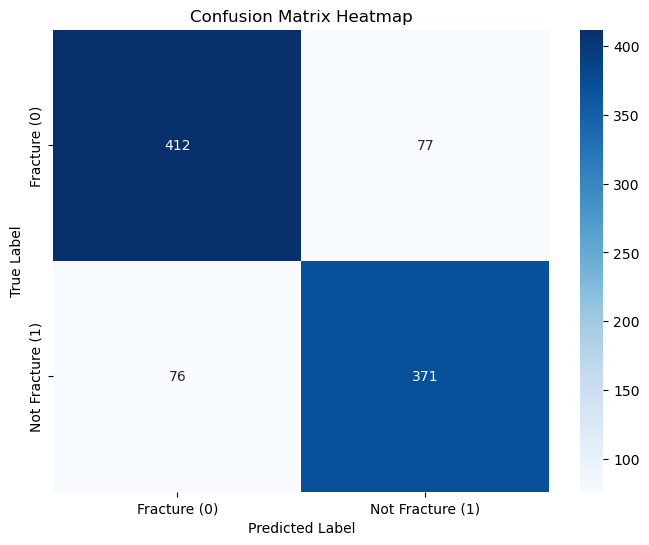

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

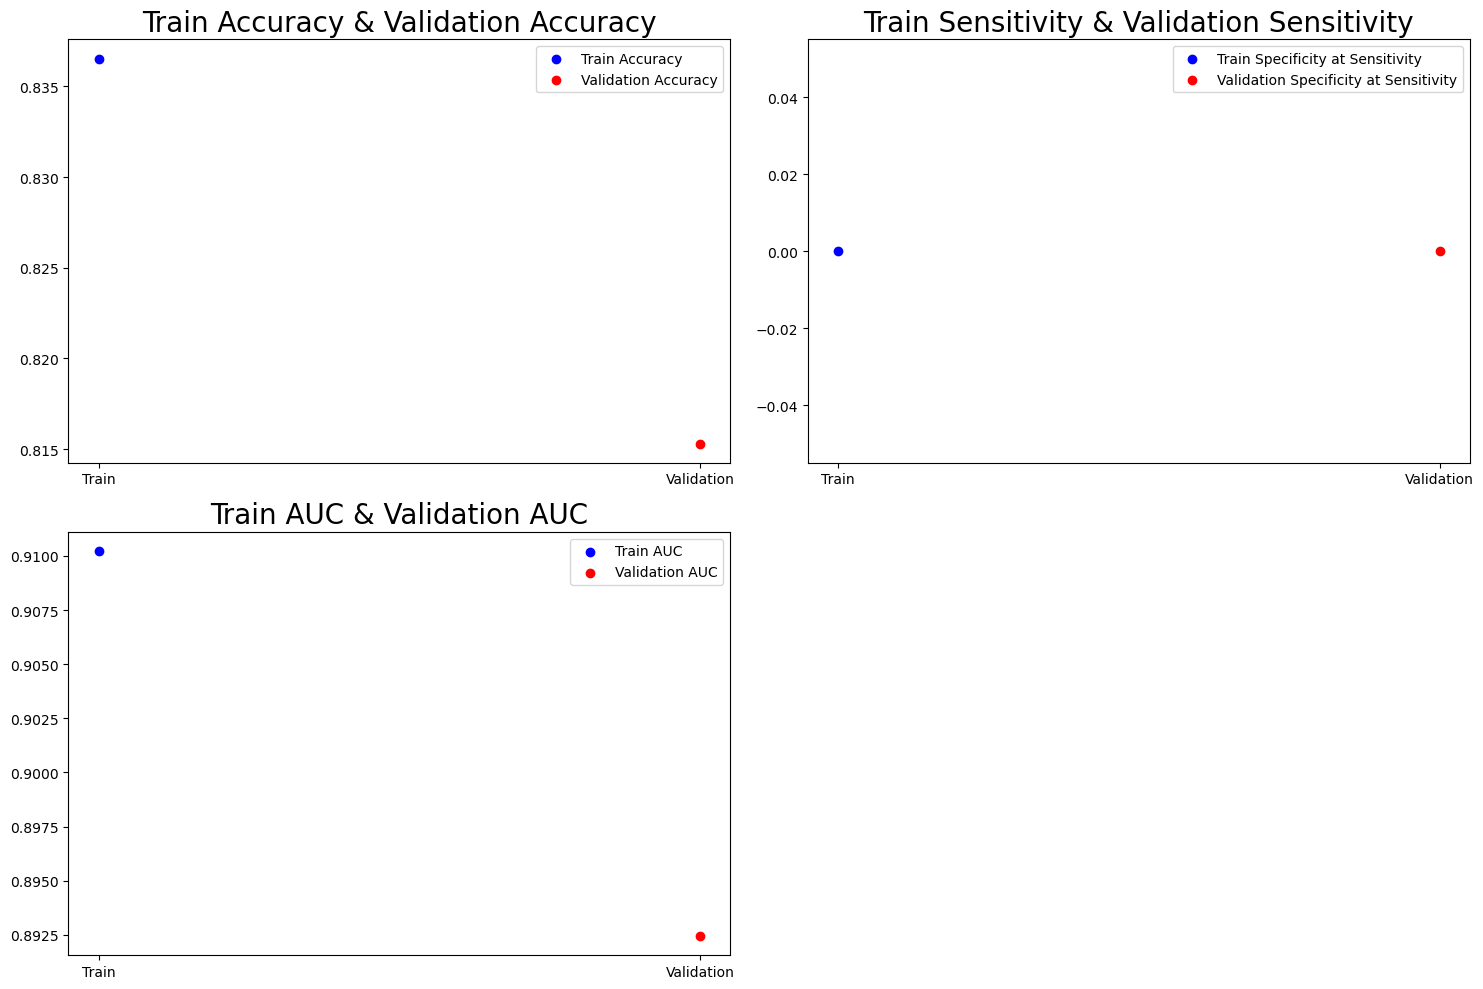

In [38]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(['Train'], hist_['accuracy'], color='b', label='Train Accuracy')
plt.scatter(['Validation'], hist_['val_accuracy'], color='r', label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.subplot(2, 2, 2)
plt.scatter(['Train'], hist_['specificity_at_sensitivity'], color='b', label='Train Specificity at Sensitivity')
plt.scatter(['Validation'], hist_['val_specificity_at_sensitivity'], color='r', label='Validation Specificity at Sensitivity')
plt.title('Train Sensitivity & Validation Sensitivity', fontsize=20)
plt.legend()
plt.subplot(2, 2, 3)
plt.scatter(['Train'], hist_['auc'], color='b', label='Train AUC')
plt.scatter(['Validation'], hist_['val_auc'], color='r', label='Validation AUC')
plt.title('Train AUC & Validation AUC', fontsize=20)
plt.legend()

plt.tight_layout()
plt.show()